# Predicting CO2 Emissions in Rwanda

Link: https://www.kaggle.com/competitions/playground-series-s3e20/

The ability to accurately monitor carbon emissions is a critical step in the fight against climate change. Precise carbon readings allow researchers and governments to understand the sources and patterns of carbon mass output. While Europe and North America have extensive systems in place to monitor carbon emissions on the ground, there are few available in Africa.

The objective of this challenge is to create a machine learning models using open-source CO2 emissions data from Sentinel-5P satellite observations to predict future carbon emissions.

These solutions may help enable governments, and other actors to estimate carbon emission levels across Africa, even in places where on-the-ground monitoring is not possible.
Acknowledgements

We acknowledge Carbon Monitor for the use of the GRACED dataset, and special thanks Darius Moruri from Zindi for his work in preparing the dataset and starter notebooks.

## Dataset Description

The objective of this challenge is to create machine learning models that use open-source emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.

Approximately 497 unique locations were selected from multiple areas in Rwanda, with a distribution around farm lands, cities and power plants. The data for this competition is split by time; the years 2019 - 2021 are included in the training data, and your task is to predict the CO2 emissions data for 2022 through November.

Seven main features were extracted weekly from Sentinel-5P from January 2019 to November 2022. Each feature (Sulphur Dioxide, Carbon Monoxide, etc) contain sub features such as column_number_density which is the vertical column density at ground level, calculated using the DOAS technique. You can read more about each feature in the below links, including how they are measured and variable definitions. You are given the values of these features in the test set and your goal to predict CO2 emissions using time information as well as these features.

   * Sulphur Dioxide - COPERNICUS/S5P/NRTI/L3_SO2
   * Carbon Monoxide - COPERNICUS/S5P/NRTI/L3_CO
   * Nitrogen Dioxide - COPERNICUS/S5P/NRTI/L3_NO2
   * Formaldehyde - COPERNICUS/S5P/NRTI/L3_HCHO
   * UV Aerosol Index - COPERNICUS/S5P/NRTI/L3_AER_AI
   * Ozone - COPERNICUS/S5P/NRTI/L3_O3
   * Cloud - COPERNICUS/S5P/OFFL/L3_CLOUD


In [1]:
#! pip install -qU pytorch-forecasting

In [2]:
import pickle
import os
import re
import time
from typing import List, Optional, Tuple
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from IPython.display import display

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_colwidth', 3000)
pd.set_option('display.max_columns', None)


# Read data

In [3]:
df = pd.read_csv("data/train.csv")    
df["emission_log"] = np.log(df["emission"])
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['week_no'].astype(str) + '-1', format='%Y-%W-%w') 
df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,emission_log,date
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,-130.050797,35.874496,-0.000027,0.035370,1589.024536,4061.098145,829530.500000,71.111977,52.775928,-149.875565,25.965214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000117,0.863230,0.000038,0.255668,35.874496,-130.050797,50.843559,-98.593887,-1.280761,829864.546875,-12.628979,35.632416,-138.786446,30.752128,0.115927,2.506609,0.295663,225.731144,0.595473,-12.628979,35.632416,-138.786446,30.752128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.595473,53534.732422,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994,1.322021,2018-12-31
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,-140.874435,28.965133,0.000012,0.036526,1772.574405,1869.040414,829787.287130,-1.019594,38.982368,-140.158048,29.562000,0.000047,1.639765e-05,0.00003,0.000093,7311.869141,-1.935386,0.067038,829859.960368,5.471037,35.265195,-138.343908,30.054262,0.000170,1.172826,0.000143,0.200754,29.071781,-141.814827,43.050213,4.678839,-1.548119,829747.856973,16.152492,43.485327,-142.786141,28.573627,0.116775,2.657704,0.315733,226.172170,0.175166,24.464335,42.596541,-143.097868,28.213655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.213608,63790.296241,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176,1.392569,2019-01-07
2,ID_-0.510_29.290_2019_02,

In [4]:
# The test data consists of records from 2022 for 487 different localizations
test_df = pd.read_csv("data/test.csv")    
test_df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-0.510_29.290_2022_00,-0.51,29.29,2022,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.561522,829937.000000,-100.113785,33.696957,-133.047562,33.779572,0.112175,2.374888,0.269846,227.193100,0.485340,-100.113785,33.696957,-133.047562,33.779572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.485129,36022.027344,8472.313477,41047.937500,7472.313477,7.935617,0.240773,-100.113792,33.697044,-133.047546,33.779583
1,ID_-0.510_29.290_2022_01,-0.51,29.29,2022,1,0.000456,0.691164,0.000316,0.000000,76.239196,15.600607,-140.529848,28.896124,0.000157,0.037641,1688.656342,2814.309683,829652.957598,26.072167,25.189549,-142.612636,28.318923,0.000048,1.117653e-05,0.000037,0.000093,7311.869141,-1.416309,0.036769,829736.125000,76.239196,15.600607,-140.529848,28.896124,0.000123,0.957096,0.000058,0.000000,28.896124,-140.529848,15.600607,76.239196,-0.823662,829753.051343,-0.009998,34.745542,-139.171039,30.405075,0.112643,2.537305,0.290184,228.489219,0.515679,-0.009998,34.745542,-139.171039,30.405075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.711262,48539.737242,6476.147323,54915.708579,5476.147161,11.448437,0.293119,-30.510319,42.402593,-138.632822,31.012380
2,ID_-0.510_29.290_2022_02,-0.51,29.29,2022,2,0.000161,0.605107,0.000106,0.079870,-42.055341,39.889060,-136.908976,30.054682,0.000053,0.037795,2629.692089,3233.654973,829589.971617,14.881259,40.833582,-143.949340,26.760219,0.000055,1.679787e-05,0.000038,0.000109,8

# Data overview

In [5]:
overview_train = df.groupby(["latitude", "longitude"])["ID_LAT_LON_YEAR_WEEK"].count()
overview_test = test_df.groupby(["latitude", "longitude"])["ID_LAT_LON_YEAR_WEEK"].count()
n_locations = len(overview_train)

print(f"There are {n_locations} different locations")
print("159 time data points in the training set and 49 time data points in the testing set.")
print(f"Prediction model ought to predict new 49 datapoints for each of {n_locations}.")

There are 497 different locations
159 time data points in the training set and 49 time data points in the testing set.
Prediction model ought to predict new 49 datapoints for each of 497.


## Missing values:

In [6]:
# percentage of missing values in each column
missing = df.isnull().sum() / len(df)
missing[missing > 0].sort_values(ascending=False).head(30)

UvAerosolLayerHeight_aerosol_pressure                      0.994445
UvAerosolLayerHeight_solar_zenith_angle                    0.994445
UvAerosolLayerHeight_aerosol_height                        0.994445
UvAerosolLayerHeight_aerosol_optical_depth                 0.994445
UvAerosolLayerHeight_sensor_zenith_angle                   0.994445
UvAerosolLayerHeight_sensor_azimuth_angle                  0.994445
UvAerosolLayerHeight_solar_azimuth_angle                   0.994445
NitrogenDioxide_NO2_slant_column_number_density            0.231831
NitrogenDioxide_tropopause_pressure                        0.231831
NitrogenDioxide_tropospheric_NO2_column_number_density     0.231831
NitrogenDioxide_absorbing_aerosol_index                    0.231831
NitrogenDioxide_cloud_fraction                             0.231831
NitrogenDioxide_sensor_altitude                            0.231831
NitrogenDioxide_sensor_azimuth_angle                       0.231831
NitrogenDioxide_sensor_zenith_angle             

In [7]:
# UvAerosol columns have more than 99% missing values, so will be removed from the dataset
element = "UvAerosolLayerHeight"
regex_filter = re.compile(f'^{element}')
columns = [column for column in df.columns if regex_filter.match(column)]
df.drop(columns, axis=1, inplace=True)

# Average yearly emissions based on localization

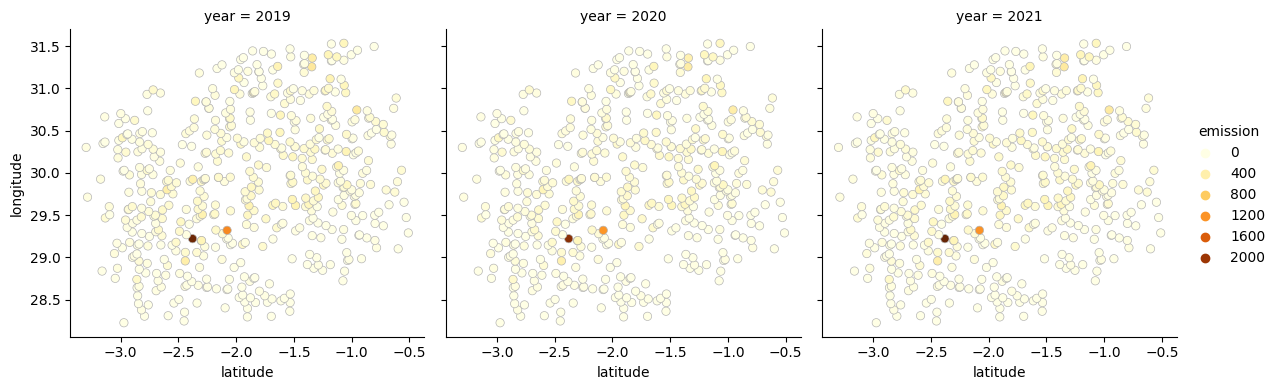

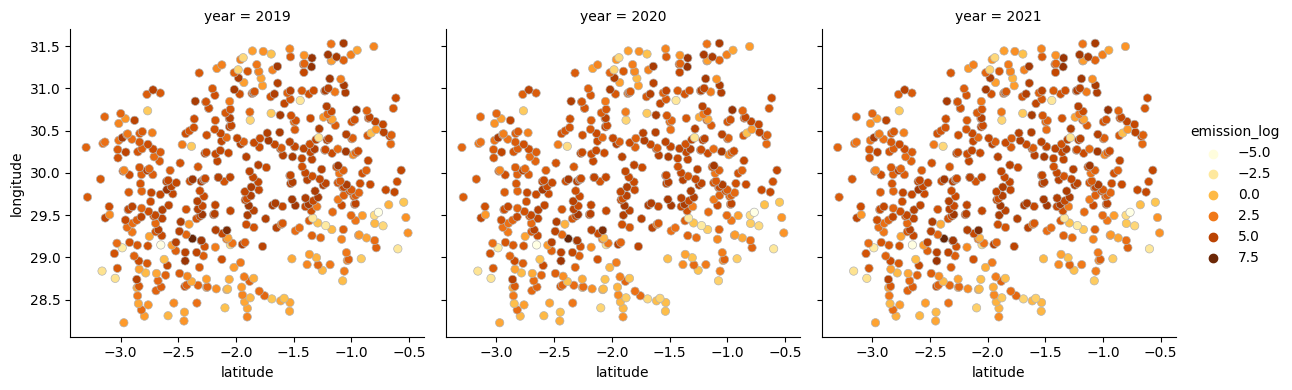

In [8]:
mean_yearly_emissions_df = df.groupby(["longitude", "latitude", "year"])["emission"].mean().reset_index()

sns.relplot(
    data=mean_yearly_emissions_df,
    x="latitude", y="longitude", hue="emission",
    palette="YlOrBr", edgecolor=".7", height=4, col="year"
)
plt.show()

mean_yearly_emissions_df = df.groupby(["longitude", "latitude", "year"])["emission_log"].mean().reset_index()
sns.relplot(
    data=mean_yearly_emissions_df,
    x="latitude", y="longitude", hue="emission_log",
    palette="YlOrBr", edgecolor=".7",
    height=4, col="year"
)
plt.show()

## Time series

In [9]:
def q10(x):
    return x.quantile(0.1)

def q25(x):
    return x.quantile(0.25)

def q50(x):
    return x.quantile(0.5)

def q75(x):
    return x.quantile(0.75)

def q90(x):
    return x.quantile(0.9)

mean_emissions_df = df.groupby("date")["emission"].agg(Mean="mean", q_10=q10, q_25=q25, q_50=q50, q_75=q75, q_90=q90)
mean_emissions_df.head()


,Mean,q_10,q_25,q_50,q_75,q_90
date,,,,,,
2018-12-31,76.739149,1.010258,9.756213,41.193130,96.653946,163.697564
2019-01-07,82.376350,1.004544,9.947974,43.580956,105.469840,175.971772
2019-01-14,86.008823,0.989036,10.263707,45.942554,110.093420,185.659272
2019-01-21,87.903964,1.004204,10.442887,46.912636,112.765480,189.896292
2019-01-28,89.595095,0.990952,10.481367,47.589570,114.985886,194.491130


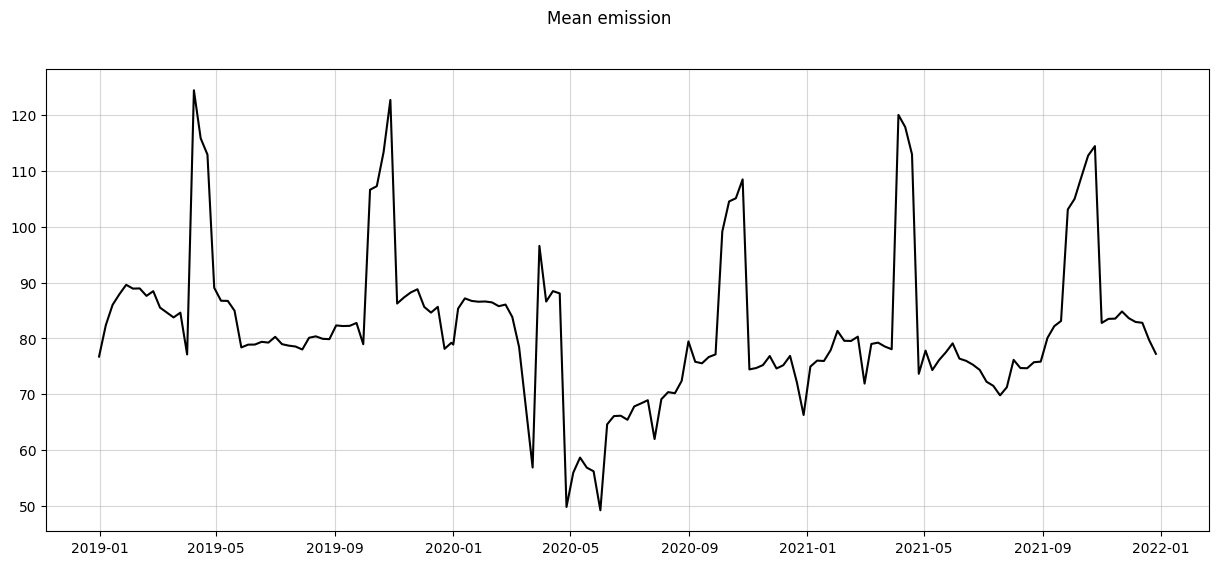

In [10]:
fig, ax = plt.subplots(1,1, figsize=(15, 6))
ax.plot(mean_emissions_df.index, mean_emissions_df["Mean"], color = "black")
ax.grid(alpha=0.5)
fig.suptitle("Mean emission")
fig.show()

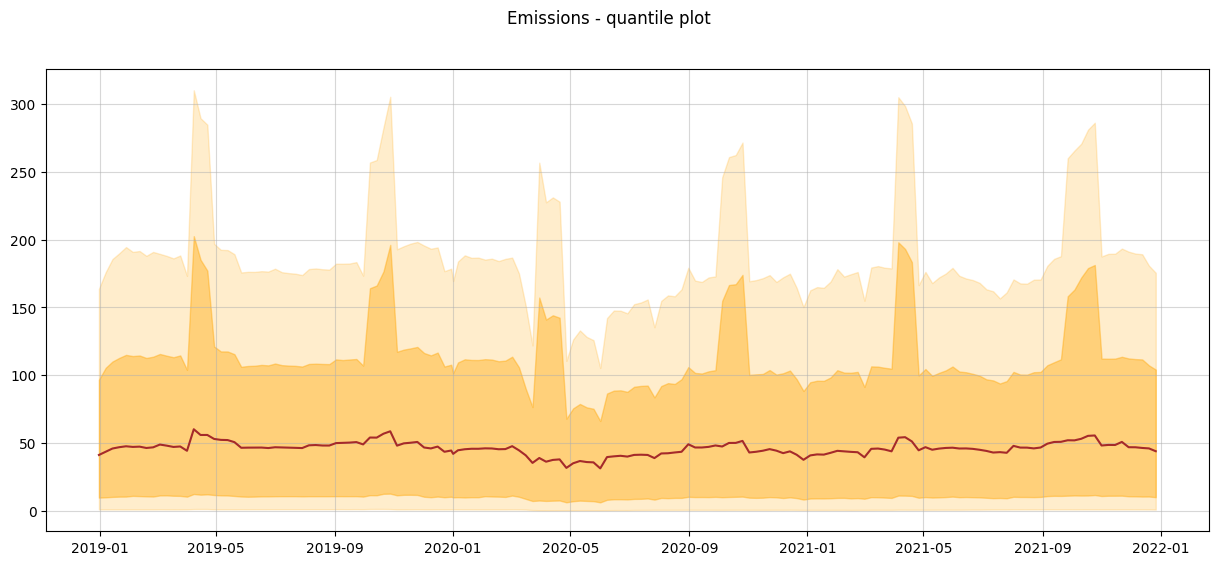

In [11]:
fig, ax = plt.subplots(1,1, figsize=(15, 6))
ax.plot(mean_emissions_df.index, mean_emissions_df["q_50"], color = "brown")
ax.fill_between(mean_emissions_df.index, mean_emissions_df['q_10'], mean_emissions_df['q_90'], color='orange', alpha=.2)
ax.fill_between(mean_emissions_df.index, mean_emissions_df['q_25'], mean_emissions_df['q_75'], color='orange', alpha=.4)
ax.grid(alpha=0.5)
fig.suptitle("Emissions - quantile plot")
fig.show()

In [12]:
df["Mask"] = 1
df.loc[(df["year"] == 2020) & (df["week_no"] < 36)  & (df["week_no"] > 10), "Mask"] = 0


# Correlations in the input data

In [13]:
df.set_index(["latitude", "longitude", "year", "week_no"], inplace=True)

regex_filter = re.compile('.*_(angle|altitude)$')
position_columns = [column for column in df.columns if regex_filter.match(column)]
print(f"\n\nColumns concerning sensor positions:\n{position_columns}")

value_columns = [column for column in df.columns if column not in position_columns]
value_columns = [col for col in value_columns if col not in ["date", "emission_log", "ID_LAT_LON_YEAR_WEEK"]]
print(f"\n\nColumns concerning sensor values:\n{value_columns}")



Columns concerning sensor positions:
['SulphurDioxide_sensor_azimuth_angle', 'SulphurDioxide_sensor_zenith_angle', 'SulphurDioxide_solar_azimuth_angle', 'SulphurDioxide_solar_zenith_angle', 'CarbonMonoxide_sensor_altitude', 'CarbonMonoxide_sensor_azimuth_angle', 'CarbonMonoxide_sensor_zenith_angle', 'CarbonMonoxide_solar_azimuth_angle', 'CarbonMonoxide_solar_zenith_angle', 'NitrogenDioxide_sensor_altitude', 'NitrogenDioxide_sensor_azimuth_angle', 'NitrogenDioxide_sensor_zenith_angle', 'NitrogenDioxide_solar_azimuth_angle', 'NitrogenDioxide_solar_zenith_angle', 'Formaldehyde_solar_zenith_angle', 'Formaldehyde_solar_azimuth_angle', 'Formaldehyde_sensor_zenith_angle', 'Formaldehyde_sensor_azimuth_angle', 'UvAerosolIndex_sensor_altitude', 'UvAerosolIndex_sensor_azimuth_angle', 'UvAerosolIndex_sensor_zenith_angle', 'UvAerosolIndex_solar_azimuth_angle', 'UvAerosolIndex_solar_zenith_angle', 'Ozone_sensor_azimuth_angle', 'Ozone_sensor_zenith_angle', 'Ozone_solar_azimuth_angle', 'Ozone_solar_

# Feature engineering

In [14]:
def show_correlations(columns, title = "Correlation Matrix"):
    if "emission" not in columns:
        columns.append("emission")
    tmp_df = df[columns]    
    f = plt.figure(figsize=(12, 14))
    plt.matshow(tmp_df.corr(), fignum=f.number, cmap="YlOrBr")
    plt.xticks(range(tmp_df.select_dtypes(['number']).shape[1]), columns, fontsize=14, rotation=85)
    plt.yticks(range(tmp_df.select_dtypes(['number']).shape[1]), columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title(title, fontsize=16);

### Correlations for sensor positions



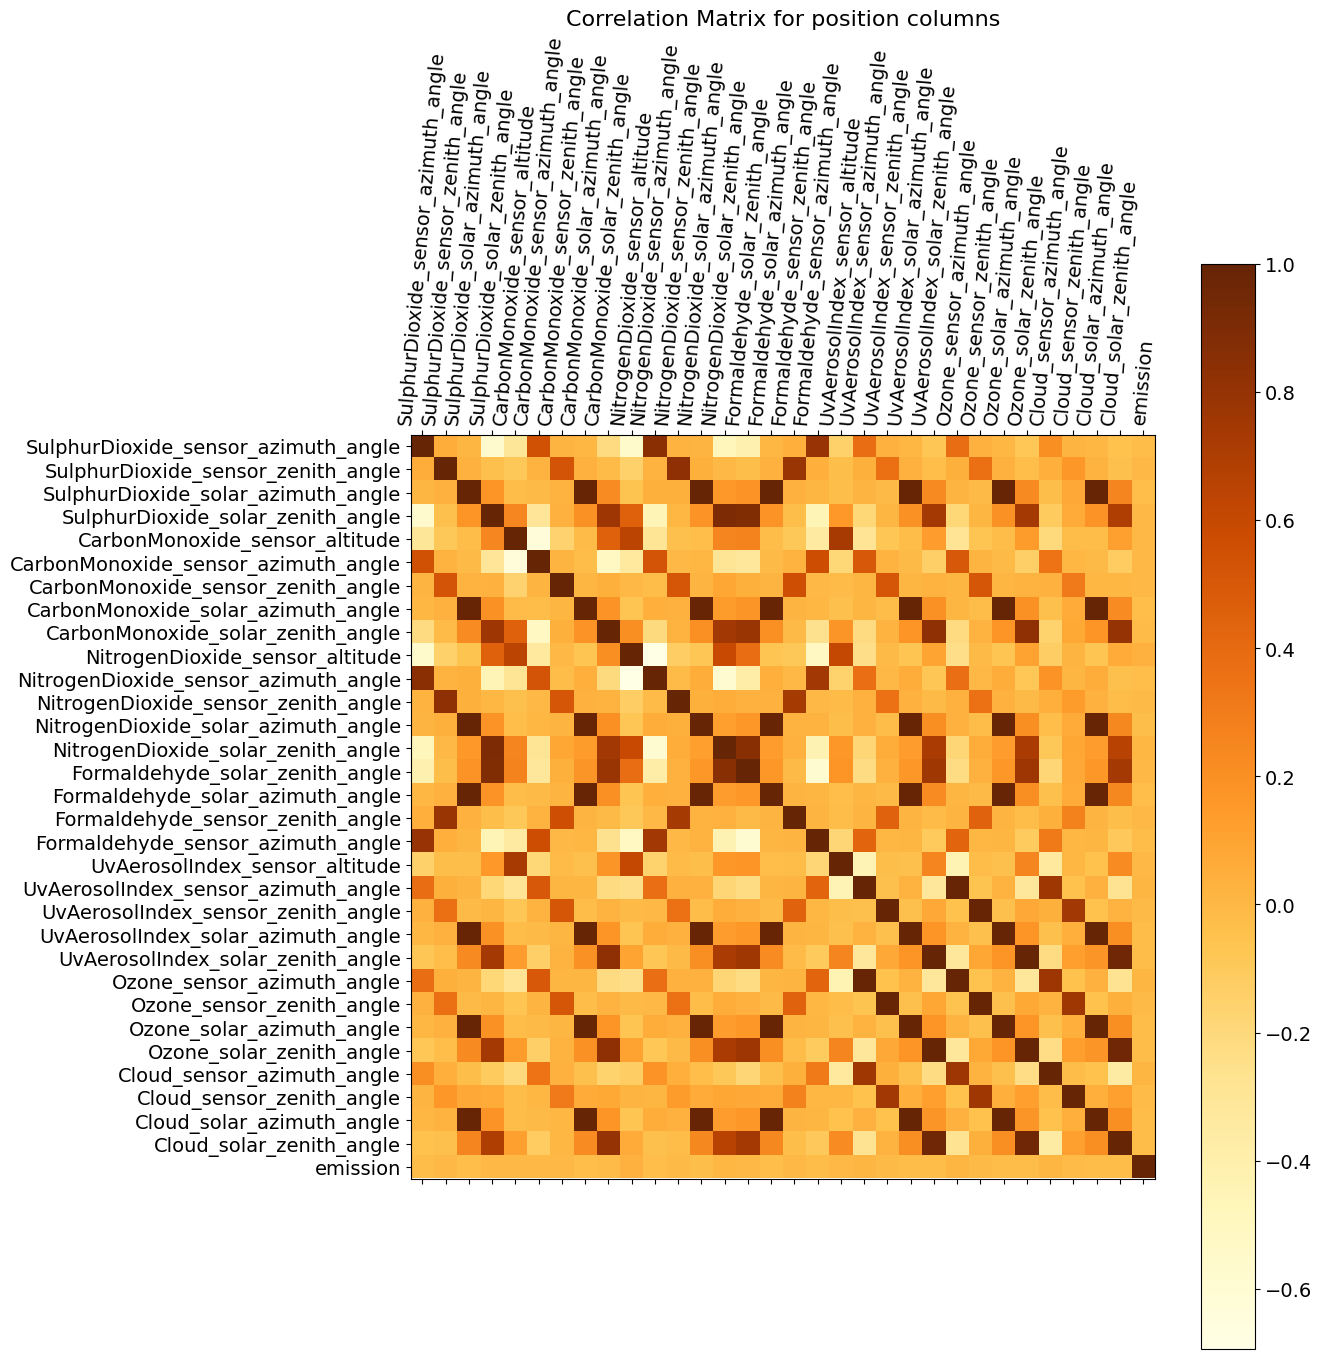

In [15]:
show_correlations(columns = position_columns, title='Correlation Matrix for position columns')

There are strong correlations between positions of SulphurDioxide, CarbonMonooxide, NitrogenDioxide and Formalhyde sensors
and between positions of Ozone, Cloud and UvAerosol sensors.

Sensor positions for SulphurDioxide and Cloud Solar will be used as representtives of all the other sensor positions

### Correlations for sensor values


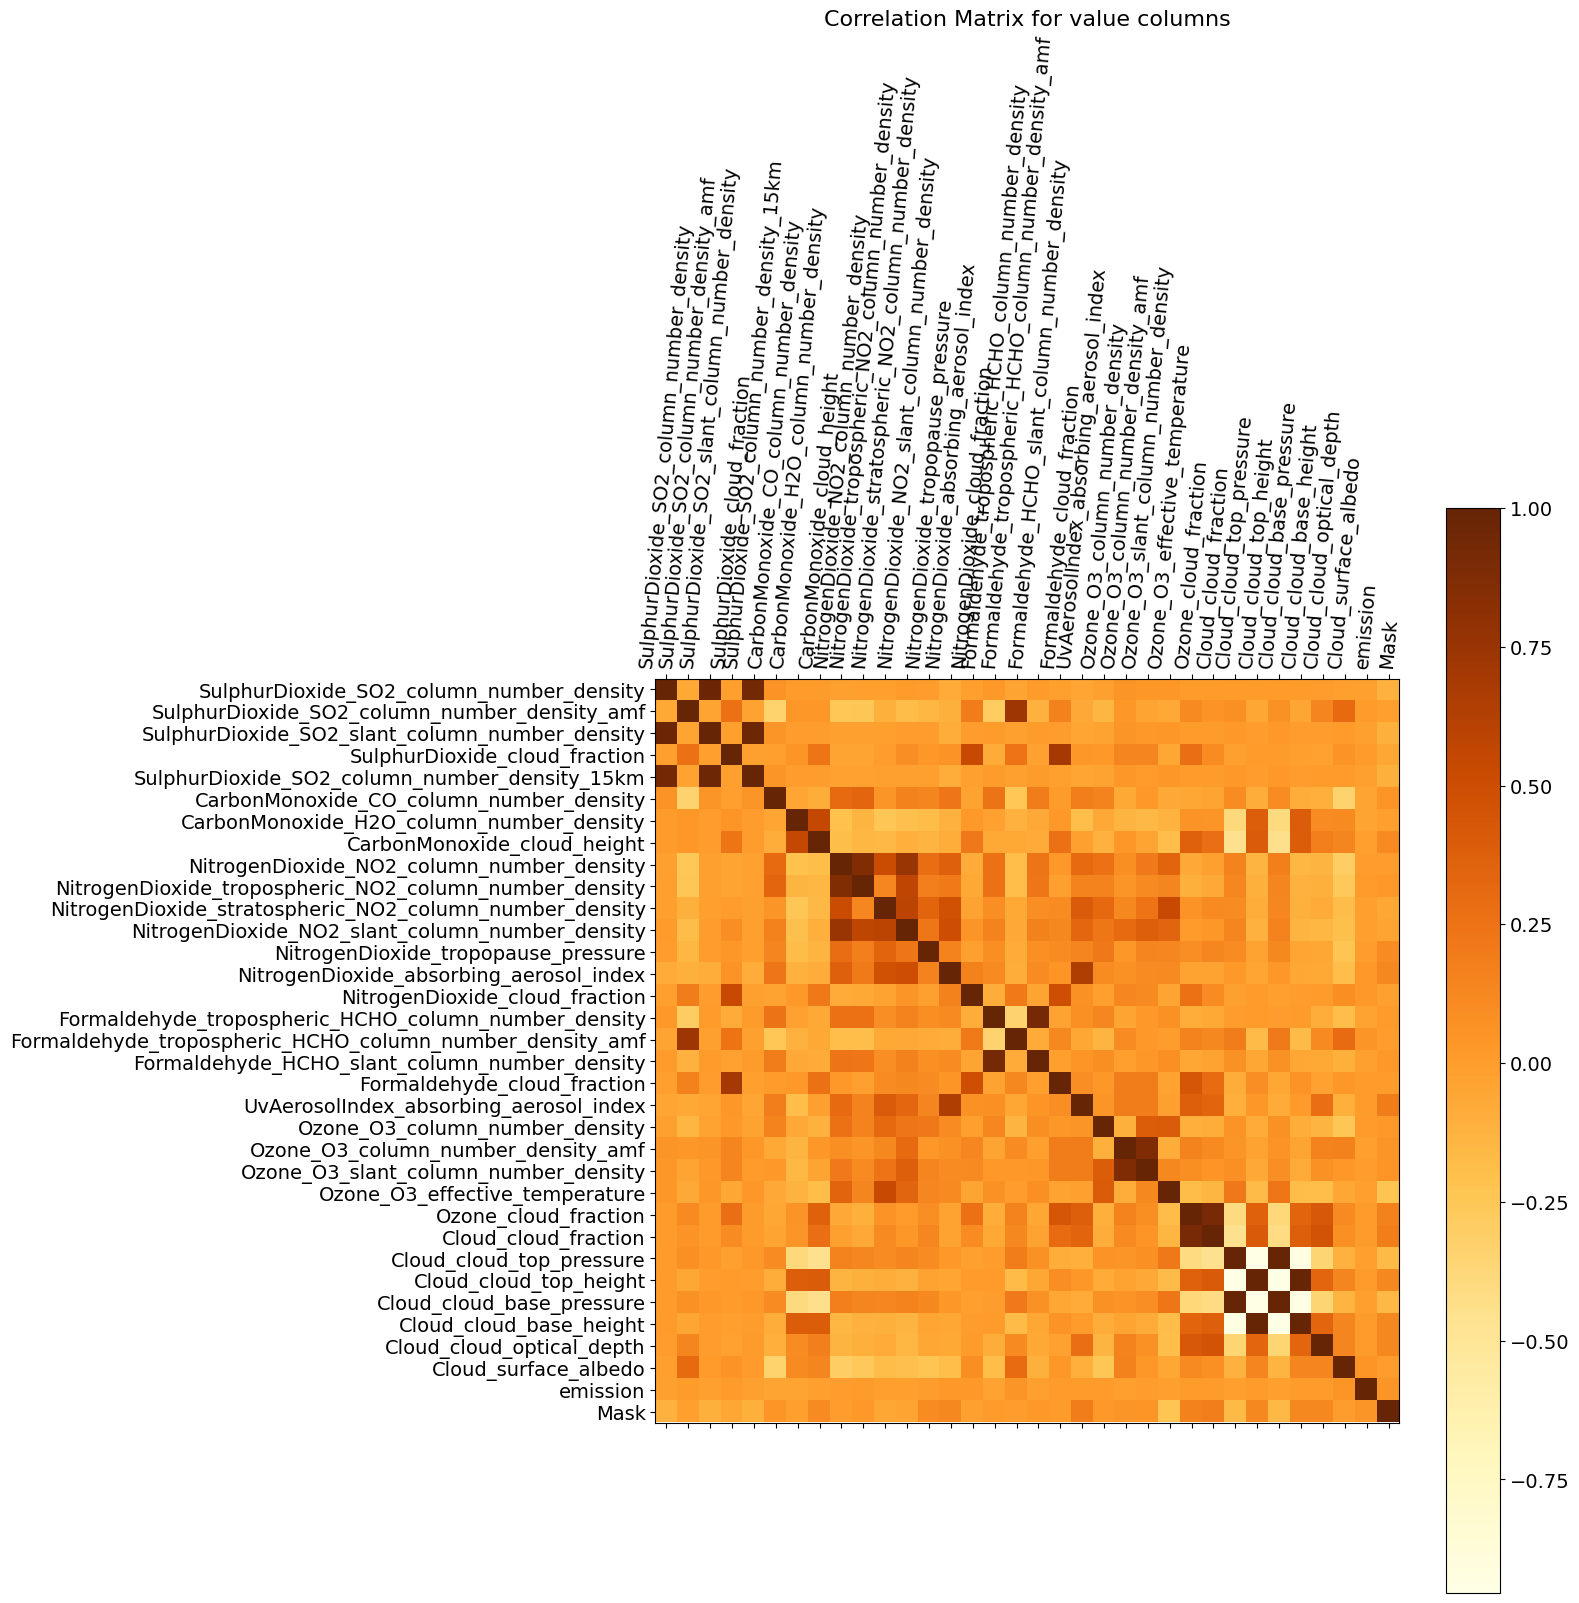

In [16]:
show_correlations(columns = value_columns, title='Correlation Matrix for value columns')

# Create time series dataset

In [17]:
df.reset_index(inplace=True)
df["relative_year"] = df["year"] - df["year"].min()
df["time_idx"] = df["relative_year"] * 53 + df["week_no"]

df.drop(['emission_log', 'date',"year"], axis=1, inplace=True)
df.head()

,latitude,longitude,week_no,ID_LAT_LON_YEAR_WEEK,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,Mask,relative_year,time_idx
0,-0.51,29.29,0,ID_-0.510_29.290_2019_00,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,-130.050797,35.874496,-0.000027,0.035370,1589.024536,4061.098145,829530.500000,71.111977,52.775928,-149.875565,25.965214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000117,0.863230,0.000038,0.255668,35.874496,-130.050797,50.843559,-98.593887,-1.280761,829864.546875,-12.628979,35.632416,-138.786446,30.752128,0.115927,2.506609,0.295663,225.731144,0.595473,-12.628979,35.632416,-138.786446,30.752128,0.595473,53534.732422,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994,1,0,0
1,-0.51,29.29,1,ID_-0.510_29.290_2019_01,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,-140.874435,28.965133,0.000012,0.036526,1772.574405,1869.040414,829787.287130,-1.019594,38.982368,-140.158048,29.562000,0.000047,1.639765e-05,0.00003,0.000093,7311.869141,-1.935386,0.067038,829859.960368,5.471037,35.265195,-138.343908,30.054262,0.000170,1.172826,0.000143,0.200754,29.071781,-141.814827,43.050213,4.678839,-1.548119,829747.856973,16.152492,43.485327,-142.786141,28.573627,0.116775,2.657704,0.315733,226.172170,0.175166,24.464335,42.596541,-143.097868,28.213655,0.213608,63790.296241,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176,1,0,1
2,-0.51,29.29,2,ID_-0.510_29.290_2019_02,0.000514,0.748199,0.000385,0.110018,72.795837,52.868816,-150.191757,23.206415,0.000154,0.035338,2703.236800,2809.138386,829883.828686,-54.801144,52.344378,-133.683714,31.586838,0.000031,4.267369e-07,0.00003,0.000080,7311.869141,-2.754374,0.072135,829527.125000,72.795837,52.868816,-150.191757,23.206415,0.000080,1.175467,0.000019,0.279449,30.994290,-135.66

In [18]:
time_varying_known_reals = value_columns + ["week_no", "relative_year"] 
time_varying_known_reals += ['CarbonMonoxide_sensor_altitude', 'CarbonMonoxide_sensor_altitude', 
                            'CarbonMonoxide_sensor_azimuth_angle', 'CarbonMonoxide_sensor_zenith_angle',
                            'CarbonMonoxide_solar_azimuth_angle', 'CarbonMonoxide_solar_zenith_angle',
                            'Cloud_sensor_azimuth_angle', 'Cloud_sensor_zenith_angle', 
                            'Cloud_solar_azimuth_angle', 'Cloud_solar_zenith_angle'
                           ]
time_varying_known_reals.remove("emission")
time_varying_known_reals

['SulphurDioxide_SO2_column_number_density',
 'SulphurDioxide_SO2_column_number_density_amf',
 'SulphurDioxide_SO2_slant_column_number_density',
 'SulphurDioxide_cloud_fraction',
 'SulphurDioxide_SO2_column_number_density_15km',
 'CarbonMonoxide_CO_column_number_density',
 'CarbonMonoxide_H2O_column_number_density',
 'CarbonMonoxide_cloud_height',
 'NitrogenDioxide_NO2_column_number_density',
 'NitrogenDioxide_tropospheric_NO2_column_number_density',
 'NitrogenDioxide_stratospheric_NO2_column_number_density',
 'NitrogenDioxide_NO2_slant_column_number_density',
 'NitrogenDioxide_tropopause_pressure',
 'NitrogenDioxide_absorbing_aerosol_index',
 'NitrogenDioxide_cloud_fraction',
 'Formaldehyde_tropospheric_HCHO_column_number_density',
 'Formaldehyde_tropospheric_HCHO_column_number_density_amf',
 'Formaldehyde_HCHO_slant_column_number_density',
 'Formaldehyde_cloud_fraction',
 'UvAerosolIndex_absorbing_aerosol_index',
 'Ozone_O3_column_number_density',
 'Ozone_O3_column_number_density_amf

In [19]:
df[time_varying_known_reals].fillna(value=0, inplace=True)
df.fillna(0, inplace=True)
df[time_varying_known_reals]

,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,UvAerosolIndex_absorbing_aerosol_index,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Mask,week_no,relative_year,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,-0.000108,0.603019,-0.000065,0.255668,-0.000027,0.035370,1589.024536,4061.098145,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000117,0.863230,0.000038,0.255668,-1.280761,0.115927,2.506609,0.295663,225.731144,0.595473,0.595473,53534.732422,3664.436218,61085.809570,2615.120483,15.568533,0.272292,1,0,0,829530.500000,829530.500000,71.111977,52.775928,-149.875565,25.965214,-12.628986,35.632416,-138.786423,30.752140
1,0.000021,0.728214,0.000014,0.130988,0.000012,0.036526,1772.574405,1869.040414,0.000047,1.639765e-05,0.000030,0.000093,7311.869141,-1.935386,0.067038,0.000170,1.172826,0.000143,0.200754,-1.548119,0.116775,2.657704,0.315733,226.172170,0.175166,0.213608,63790.296241,3651.190311,66969.478735,3174.572424,8.690601,0.256830,1,1,0,829787.287130,829787.287130,-1.019594,38.982368,-140.158048,29.562000,30.359375,39.557633,-145.183930,27.251779
2,0.000514,0.748199,0.000385,0.110018,0.000154,0.035338,2703.236800,2809.138386,0.000031,4.267369e-07,0.000030,0.000080,7311.869141,-2.754374,0.072135,0.000080,1.175467,0.000019,0.279449,-1.038673,0.117039,2.619104,0.310828,227.469292,0.606091,0.703540,55923.790554,4216.986492,60068.894448,3516.282669,21.103410,0.251101,1,2,0,829883.828686,829883.828686,-54.801144,52.344378,-133.683714,31.586838,15.377883,30.401823,-142.519545,26.193296
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.036790,2076.073332,3917.707873,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.626435,0.116434,2.525818,0.297966,225.589440,0.787398,0.782806,44569.130636,5228.507736,51064.547339,4180.973322,15.386899,0.262043,1,3,0,829657.163571,829657.163571,28.916541,39.676184,-142.575915,24.810699,-11.293399,24.380357,-132.665828,28.829155
4,-0.000079,0.676296,-0.000048,0.121164,-0.000028,0.034675,2053.608490,2667.310013,0.000051,2.056437e-05,0.000030,0.000093,7637.262458,-1.450563,0.049393,0.000269,0.869081,0.000146,0.160090,-1.584896,0.117373,2.572243,0.306688,228.955840,0.215739,0.189336,59904.314844,3980.598120,63751.125781,3355.710107,8.114694,0.235847,1,4,0,829735.093750,829735.093750,-12.501663,33.703073,-134.854258,24.629593,38.532263,37.392979,-141.509805,22.204612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79018,0.000284,1.195643,0.000340,0.191313,0.000131,0.026488,1999.322864,2686.895807,0.000048,8.024310e-06,0.0000

In [20]:
max_pred_len = 49
max_encoder_len = 28
batch_size = 128
max_epochs = 50

training_cutoff = df["time_idx"].max() - max_pred_len

training = TimeSeriesDataSet(
            df[lambda x: x.time_idx <= training_cutoff],
            time_idx="time_idx",
            target="emission",
            group_ids = ["latitude", "longitude"],
            #static_reals=["latitude", "longitude"],
            time_varying_known_reals= time_varying_known_reals, 
            time_varying_unknown_reals=["emission"],
            min_encoder_length=max_encoder_len // 2,
            max_encoder_length=max_encoder_len,
            min_prediction_length=1,
            max_prediction_length=max_pred_len,
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
            allow_missing_timesteps=False,
            target_normalizer=GroupNormalizer(
                groups=["latitude", "longitude"], transformation="softplus"),  
        )

# create validation set that aims to predict the last max_encoder_len points for each time series
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for model
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=1)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=1)

# Find the best hyperparameters

In [21]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100,
    max_epochs=max_epochs,
    gradient_clip_val_range=(0.1, 1.0),
    hidden_size_range=(6, 16),
    hidden_continuous_size_range=(4, 16),
    attention_head_size_range=(3, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30, accelerator="gpu"),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=True,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-08-21 06:52:32,798] A new study created in memory with name: no-name-47e223c9-cc9d-4320-b7c1-29789ce0692c
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.006606934480075959
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_6dda5c13-df36-4175-b09f-9b35b13a945a.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_6dda5c13-df36-4175-b09f-9b35b13a945a.ckpt
[I 2023-08-21 06:53:16,071] Using learning rate of 0.0132
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 07:05:31,655] Trial 0 finished with value: 10.837569236755371 and parameters: {'gradient_clip_val': 0.7221516475441858, 'hidden_size': 9, 'dropout': 0.16654047832352079, 'hidden_continuous_size': 7, 'attention_head_size': 4, 'learning_rate': 0.013182567385564075}. Best is trial 0 with value: 10.837569236755371.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, u

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00457088189614875
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_3c80d45f-5fee-4636-86ec-13827d0d2dba.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_3c80d45f-5fee-4636-86ec-13827d0d2dba.ckpt
[I 2023-08-21 07:06:10,015] Using learning rate of 0.0115
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 07:16:14,954] Trial 1 finished with value: 12.09433650970459 and parameters: {'gradient_clip_val': 0.5890292391963713, 'hidden_size': 12, 'dropout': 0.12776843100827306, 'hidden_continuous_size': 4, 'attention_head_size': 3, 'learning_rate': 0.01148153621496883}. Best is trial 0 with value: 10.837569236755371.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usi

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.009120108393559097
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_c56eb6b6-6941-4d19-90af-0f595b6dd4b6.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_c56eb6b6-6941-4d19-90af-0f595b6dd4b6.ckpt
[I 2023-08-21 07:17:00,877] Using learning rate of 0.01
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 07:29:13,641] Trial 2 finished with value: 7.630918025970459 and parameters: {'gradient_clip_val': 0.8874689737157719, 'hidden_size': 9, 'dropout': 0.2803801153309584, 'hidden_continuous_size': 5, 'attention_head_size': 4, 'learning_rate': 0.01}. Best is trial 2 with value: 7.630918025970459.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU avai

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0016595869074375606
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_ce4a66c7-2f59-4426-9070-b79158d058d6.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_ce4a66c7-2f59-4426-9070-b79158d058d6.ckpt
[I 2023-08-21 07:29:58,553] Using learning rate of 0.0575
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 07:41:50,448] Trial 3 finished with value: 8.525675773620605 and parameters: {'gradient_clip_val': 0.412011157691822, 'hidden_size': 7, 'dropout': 0.1752813763499669, 'hidden_continuous_size': 5, 'attention_head_size': 3, 'learning_rate': 0.057543993733715694}. Best is trial 2 with value: 7.630918025970459.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0019952623149688794
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_56e2e3fb-2a77-4fa7-978c-478038257249.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_56e2e3fb-2a77-4fa7-978c-478038257249.ckpt
[I 2023-08-21 07:42:29,011] Using learning rate of 0.00724
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 07:52:37,985] Trial 4 finished with value: 6.945131301879883 and parameters: {'gradient_clip_val': 0.7762092818030014, 'hidden_size': 8, 'dropout': 0.21175759145637324, 'hidden_continuous_size': 5, 'attention_head_size': 4, 'learning_rate': 0.007244359600749901}. Best is trial 4 with value: 6.945131301879883.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, u

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.003019951720402016
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_b1225c1e-6d3e-4667-aa2c-038dbbf332f9.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_b1225c1e-6d3e-4667-aa2c-038dbbf332f9.ckpt
[I 2023-08-21 07:53:27,976] Using learning rate of 0.011
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 08:06:51,660] Trial 5 finished with value: 8.607056617736816 and parameters: {'gradient_clip_val': 0.6750834707949908, 'hidden_size': 13, 'dropout': 0.19359422966932344, 'hidden_continuous_size': 9, 'attention_head_size': 3, 'learning_rate': 0.010964781961431852}. Best is trial 4 with value: 6.945131301879883.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usi

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.009120108393559097
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_ddd5ba33-ee4e-4555-b75f-c1b07ff0fb43.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_ddd5ba33-ee4e-4555-b75f-c1b07ff0fb43.ckpt
[I 2023-08-21 08:07:39,065] Using learning rate of 0.0229
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 08:20:17,549] Trial 6 finished with value: 6.892422676086426 and parameters: {'gradient_clip_val': 0.9320025890846881, 'hidden_size': 11, 'dropout': 0.19728749629594888, 'hidden_continuous_size': 6, 'attention_head_size': 4, 'learning_rate': 0.022908676527677734}. Best is trial 6 with value: 6.892422676086426.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, us

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0027542287033381664
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_97a63a04-3c73-4494-b093-de49309c66a9.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_97a63a04-3c73-4494-b093-de49309c66a9.ckpt
[I 2023-08-21 08:21:10,970] Using learning rate of 0.00724
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 08:35:21,946] Trial 7 finished with value: 8.841812133789062 and parameters: {'gradient_clip_val': 0.10987812591639694, 'hidden_size': 15, 'dropout': 0.19544273511043542, 'hidden_continuous_size': 9, 'attention_head_size': 3, 'learning_rate': 0.007244359600749901}. Best is trial 6 with value: 6.892422676086426.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False,

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0034673685045253167
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_3c8e68f6-9b8c-4a0d-beb2-2d64348570cd.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_3c8e68f6-9b8c-4a0d-beb2-2d64348570cd.ckpt
[I 2023-08-21 08:36:10,870] Using learning rate of 0.00794
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 08:49:10,764] Trial 8 finished with value: 6.471465110778809 and parameters: {'gradient_clip_val': 0.4123280620295357, 'hidden_size': 14, 'dropout': 0.14685694052584627, 'hidden_continuous_size': 5, 'attention_head_size': 3, 'learning_rate': 0.007943282347242816}. Best is trial 8 with value: 6.471465110778809.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0047863009232263845
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_db280a69-8980-4843-b4e8-caec04f3f66e.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_db280a69-8980-4843-b4e8-caec04f3f66e.ckpt
[I 2023-08-21 08:49:58,014] Using learning rate of 0.00724
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 09:02:26,976] Trial 9 finished with value: 8.342602729797363 and parameters: {'gradient_clip_val': 0.56192684790946, 'hidden_size': 13, 'dropout': 0.13221279430115643, 'hidden_continuous_size': 4, 'attention_head_size': 3, 'learning_rate': 0.007244359600749901}. Best is trial 8 with value: 6.471465110778809.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, us

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0026302679918953817
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_c3a703c0-e9b2-4a79-95bd-e964d24e2808.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_c3a703c0-e9b2-4a79-95bd-e964d24e2808.ckpt
[I 2023-08-21 09:03:14,136] Using learning rate of 0.00955
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 09:15:43,073] Trial 10 finished with value: 11.155404090881348 and parameters: {'gradient_clip_val': 0.2800450525502942, 'hidden_size': 16, 'dropout': 0.1024064885340351, 'hidden_continuous_size': 14, 'attention_head_size': 3, 'learning_rate': 0.009549925860214359}. Best is trial 8 with value: 6.471465110778809.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00831763771102671
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_1618c853-05da-4324-93d2-4684379f01f1.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_1618c853-05da-4324-93d2-4684379f01f1.ckpt
[I 2023-08-21 09:16:31,098] Using learning rate of 0.00871
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 09:29:12,722] Trial 11 finished with value: 8.537464141845703 and parameters: {'gradient_clip_val': 0.9874877192032978, 'hidden_size': 11, 'dropout': 0.22728517552620953, 'hidden_continuous_size': 6, 'attention_head_size': 4, 'learning_rate': 0.008709635899560805}. Best is trial 8 with value: 6.471465110778809.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, u

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.003630780547701014
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_456eface-3dc9-4115-afbc-71133be8cee9.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_456eface-3dc9-4115-afbc-71133be8cee9.ckpt
[I 2023-08-21 09:30:00,485] Using learning rate of 0.0302
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 09:42:46,915] Trial 12 finished with value: 5.7543416023254395 and parameters: {'gradient_clip_val': 0.34047499118058117, 'hidden_size': 11, 'dropout': 0.15279555679808057, 'hidden_continuous_size': 6, 'attention_head_size': 4, 'learning_rate': 0.03019951720402016}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0025118864315095803
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_561f660c-0c8c-435a-b2bc-c90606a08610.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_561f660c-0c8c-435a-b2bc-c90606a08610.ckpt
[I 2023-08-21 09:43:33,324] Using learning rate of 0.00302
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 09:55:53,695] Trial 13 finished with value: 10.132645606994629 and parameters: {'gradient_clip_val': 0.3374472859155699, 'hidden_size': 10, 'dropout': 0.15249576776509244, 'hidden_continuous_size': 4, 'attention_head_size': 4, 'learning_rate': 0.003019951720402016}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: Fal

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0026302679918953817
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_f73e37c3-82fc-4ada-8f89-2ffb0c5dd52f.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_f73e37c3-82fc-4ada-8f89-2ffb0c5dd52f.ckpt
[I 2023-08-21 09:56:38,345] Using learning rate of 0.0138
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 10:08:26,550] Trial 14 finished with value: 6.906158447265625 and parameters: {'gradient_clip_val': 0.24622283869726416, 'hidden_size': 6, 'dropout': 0.14060510846599816, 'hidden_continuous_size': 4, 'attention_head_size': 3, 'learning_rate': 0.013803842646028847}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00457088189614875
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_4c68bc90-b933-475b-9962-7fc8070ff8cd.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_4c68bc90-b933-475b-9962-7fc8070ff8cd.ckpt
[I 2023-08-21 10:09:17,776] Using learning rate of 0.00631
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 10:22:58,557] Trial 15 finished with value: 9.08973217010498 and parameters: {'gradient_clip_val': 0.43344149408548793, 'hidden_size': 14, 'dropout': 0.1016676610721072, 'hidden_continuous_size': 7, 'attention_head_size': 4, 'learning_rate': 0.006309573444801934}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0038018939632056114
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_1a3ca1ed-57c2-4bdd-a3c9-1bfe239fae5d.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_1a3ca1ed-57c2-4bdd-a3c9-1bfe239fae5d.ckpt
[I 2023-08-21 10:23:44,658] Using learning rate of 0.00347
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 10:36:03,296] Trial 16 finished with value: 9.623123168945312 and parameters: {'gradient_clip_val': 0.2163169799570225, 'hidden_size': 16, 'dropout': 0.16756400814390832, 'hidden_continuous_size': 9, 'attention_head_size': 3, 'learning_rate': 0.0034673685045253167}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: Fal

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0022908676527677732
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_b2b21165-4978-446f-ac14-95e4e62f7800.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_b2b21165-4978-446f-ac14-95e4e62f7800.ckpt
[I 2023-08-21 10:36:53,706] Using learning rate of 0.0145
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 10:50:16,958] Trial 17 finished with value: 9.856439590454102 and parameters: {'gradient_clip_val': 0.46122003161398806, 'hidden_size': 14, 'dropout': 0.1232171788183653, 'hidden_continuous_size': 6, 'attention_head_size': 4, 'learning_rate': 0.014454397707459272}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0019054607179632473
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_6ec8455c-fc73-4cc7-94e3-73b115783f8d.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_6ec8455c-fc73-4cc7-94e3-73b115783f8d.ckpt
[I 2023-08-21 10:50:57,103] Using learning rate of 0.00912
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 11:01:25,628] Trial 18 finished with value: 8.141408920288086 and parameters: {'gradient_clip_val': 0.3373730559708157, 'hidden_size': 12, 'dropout': 0.15822453502365721, 'hidden_continuous_size': 5, 'attention_head_size': 4, 'learning_rate': 0.009120108393559097}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: Fals

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0018197008586099835
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_92e5f358-9ae8-45f8-9d69-82cbaa49da38.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_92e5f358-9ae8-45f8-9d69-82cbaa49da38.ckpt
[I 2023-08-21 11:02:13,054] Using learning rate of 0.00871
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 11:14:46,599] Trial 19 finished with value: 7.2791571617126465 and parameters: {'gradient_clip_val': 0.18897549266583472, 'hidden_size': 10, 'dropout': 0.1386569378483975, 'hidden_continuous_size': 5, 'attention_head_size': 3, 'learning_rate': 0.008709635899560805}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: Fal

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0019952623149688794
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_caa08f9e-6f33-4630-991d-60605ac525c8.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_caa08f9e-6f33-4630-991d-60605ac525c8.ckpt
[I 2023-08-21 11:15:35,137] Using learning rate of 0.0126
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 11:28:37,382] Trial 20 finished with value: 10.215618133544922 and parameters: {'gradient_clip_val': 0.4917195743672342, 'hidden_size': 11, 'dropout': 0.17922736027542352, 'hidden_continuous_size': 7, 'attention_head_size': 4, 'learning_rate': 0.012589254117941675}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: Fals

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0033113112148259113
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_ae1a2c0f-dbbc-446c-b61b-b93f44a2ac9b.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_ae1a2c0f-dbbc-446c-b61b-b93f44a2ac9b.ckpt
[I 2023-08-21 11:29:25,426] Using learning rate of 0.012
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 11:42:14,246] Trial 21 finished with value: 8.336244583129883 and parameters: {'gradient_clip_val': 0.6139984185117373, 'hidden_size': 11, 'dropout': 0.22632017126918125, 'hidden_continuous_size': 6, 'attention_head_size': 4, 'learning_rate': 0.012022644346174132}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False,

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0025118864315095803
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_af2a3d6f-7b54-4dda-8b08-1fa0ff156ed8.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_af2a3d6f-7b54-4dda-8b08-1fa0ff156ed8.ckpt
[I 2023-08-21 11:42:54,850] Using learning rate of 0.0151
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 11:53:40,005] Trial 22 finished with value: 8.343120574951172 and parameters: {'gradient_clip_val': 0.8642931841955135, 'hidden_size': 12, 'dropout': 0.18269137529368365, 'hidden_continuous_size': 6, 'attention_head_size': 4, 'learning_rate': 0.01513561248436208}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False,

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0047863009232263845
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_0a8d2344-1b7c-4d86-afea-c154b05280de.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_0a8d2344-1b7c-4d86-afea-c154b05280de.ckpt
[I 2023-08-21 11:54:32,737] Using learning rate of 0.00501
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 12:08:31,906] Trial 23 finished with value: 7.044905185699463 and parameters: {'gradient_clip_val': 0.3847681390073351, 'hidden_size': 14, 'dropout': 0.1508569578505834, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'learning_rate': 0.005011872336272722}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0027542287033381664
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_1d3f5b63-86bd-4d25-96af-436fc8fe3c0a.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_1d3f5b63-86bd-4d25-96af-436fc8fe3c0a.ckpt
[I 2023-08-21 12:09:19,299] Using learning rate of 0.0182
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 12:21:52,217] Trial 24 finished with value: 8.479053497314453 and parameters: {'gradient_clip_val': 0.5368114802242274, 'hidden_size': 10, 'dropout': 0.1506858776662985, 'hidden_continuous_size': 5, 'attention_head_size': 4, 'learning_rate': 0.018197008586099836}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False,

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0019952623149688794
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_ef0d9665-7673-441d-84a3-02c984e9f753.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_ef0d9665-7673-441d-84a3-02c984e9f753.ckpt
[I 2023-08-21 12:22:41,607] Using learning rate of 0.00661
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 12:35:49,295] Trial 25 finished with value: 10.559534072875977 and parameters: {'gradient_clip_val': 0.7151162227976896, 'hidden_size': 13, 'dropout': 0.12068518174849756, 'hidden_continuous_size': 6, 'attention_head_size': 4, 'learning_rate': 0.006606934480075959}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: Fal

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0016595869074375606
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_049cba51-a9a0-41cf-a114-e2cc8566532e.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_049cba51-a9a0-41cf-a114-e2cc8566532e.ckpt
[I 2023-08-21 12:36:38,137] Using learning rate of 0.012
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 12:49:39,915] Trial 26 finished with value: 9.775565147399902 and parameters: {'gradient_clip_val': 0.5100026869966944, 'hidden_size': 11, 'dropout': 0.1664174287733391, 'hidden_continuous_size': 7, 'attention_head_size': 3, 'learning_rate': 0.012022644346174132}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.012589254117941675
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_398c8712-858b-4db3-bd54-0d2daaca4b86.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_398c8712-858b-4db3-bd54-0d2daaca4b86.ckpt
[I 2023-08-21 12:50:33,729] Using learning rate of 0.0132
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 13:04:50,672] Trial 27 finished with value: 8.103232383728027 and parameters: {'gradient_clip_val': 0.38065897499491474, 'hidden_size': 15, 'dropout': 0.1832632971455872, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'learning_rate': 0.013182567385564075}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False,

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0038018939632056114
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_7f797c43-235c-40e9-809f-9335f0fd3d7b.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_7f797c43-235c-40e9-809f-9335f0fd3d7b.ckpt
[I 2023-08-21 13:05:37,868] Using learning rate of 0.00832
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 13:18:10,791] Trial 28 finished with value: 8.929842948913574 and parameters: {'gradient_clip_val': 0.29381115179515516, 'hidden_size': 9, 'dropout': 0.2072793330811314, 'hidden_continuous_size': 5, 'attention_head_size': 3, 'learning_rate': 0.00831763771102671}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False,

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0016595869074375606
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_72638038-464a-4e0d-9de1-e30b0cb147a3.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_72638038-464a-4e0d-9de1-e30b0cb147a3.ckpt
[I 2023-08-21 13:18:50,464] Using learning rate of 0.0209
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 13:29:19,295] Trial 29 finished with value: 9.156349182128906 and parameters: {'gradient_clip_val': 0.7187096121368224, 'hidden_size': 8, 'dropout': 0.16271480833146396, 'hidden_continuous_size': 6, 'attention_head_size': 4, 'learning_rate': 0.020892961308540396}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False,

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371569
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_667024c0-eb87-4707-9144-339f1e764ec7.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_667024c0-eb87-4707-9144-339f1e764ec7.ckpt
[I 2023-08-21 13:30:07,932] Using learning rate of 0.00575
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 13:43:09,663] Trial 30 finished with value: 8.470162391662598 and parameters: {'gradient_clip_val': 0.44191130899216996, 'hidden_size': 10, 'dropout': 0.1402008020008613, 'hidden_continuous_size': 7, 'attention_head_size': 4, 'learning_rate': 0.005754399373371569}. Best is trial 12 with value: 5.7543416023254395.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.002884031503126606
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_8a6548ad-b21f-401f-b0ab-92e8533efec5.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_8a6548ad-b21f-401f-b0ab-92e8533efec5.ckpt
[I 2023-08-21 13:43:55,525] Using learning rate of 0.0105
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 13:56:05,349] Trial 31 finished with value: 5.5040717124938965 and parameters: {'gradient_clip_val': 0.24854187249795376, 'hidden_size': 7, 'dropout': 0.14831947375199034, 'hidden_continuous_size': 4, 'attention_head_size': 3, 'learning_rate': 0.010471285480508996}. Best is trial 31 with value: 5.5040717124938965.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0027542287033381664
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_11e175b5-0e76-42b8-99e4-59ba90a5a3b3.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_11e175b5-0e76-42b8-99e4-59ba90a5a3b3.ckpt
[I 2023-08-21 13:56:43,719] Using learning rate of 0.0126
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 14:06:48,734] Trial 32 finished with value: 8.391136169433594 and parameters: {'gradient_clip_val': 0.618492005881887, 'hidden_size': 8, 'dropout': 0.1168543810540651, 'hidden_continuous_size': 4, 'attention_head_size': 3, 'learning_rate': 0.012589254117941675}. Best is trial 31 with value: 5.5040717124938965.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, u

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0016595869074375606
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_d0c70632-1b84-4987-b708-843ac5914a2c.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_d0c70632-1b84-4987-b708-843ac5914a2c.ckpt
[I 2023-08-21 14:07:33,622] Using learning rate of 0.00832
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 14:19:35,799] Trial 33 finished with value: 6.1369147300720215 and parameters: {'gradient_clip_val': 0.35330942533305154, 'hidden_size': 6, 'dropout': 0.14543146732322684, 'hidden_continuous_size': 4, 'attention_head_size': 3, 'learning_rate': 0.00831763771102671}. Best is trial 31 with value: 5.5040717124938965.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: Fals

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.027542287033381664
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_65c173eb-a5e3-4b21-9cb7-58626be0c182.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_65c173eb-a5e3-4b21-9cb7-58626be0c182.ckpt
[I 2023-08-21 14:20:20,775] Using learning rate of 0.02
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 14:32:18,440] Trial 34 finished with value: 7.642242431640625 and parameters: {'gradient_clip_val': 0.31800706275741775, 'hidden_size': 6, 'dropout': 0.145589956920758, 'hidden_continuous_size': 4, 'attention_head_size': 3, 'learning_rate': 0.0199526231496888}. Best is trial 31 with value: 5.5040717124938965.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.014454397707459272
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_d85bc657-2227-4c18-8e25-d162c5a6cfdc.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_d85bc657-2227-4c18-8e25-d162c5a6cfdc.ckpt
[I 2023-08-21 14:33:04,561] Using learning rate of 0.0158
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 14:45:18,169] Trial 35 finished with value: 6.789693355560303 and parameters: {'gradient_clip_val': 0.3511888626016233, 'hidden_size': 7, 'dropout': 0.13252600588435126, 'hidden_continuous_size': 4, 'attention_head_size': 3, 'learning_rate': 0.015848931924611134}. Best is trial 31 with value: 5.5040717124938965.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.006309573444801934
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_4b796034-0302-4908-8420-5eae88754d55.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Time series prediction/.lr_find_4b796034-0302-4908-8420-5eae88754d55.ckpt
[I 2023-08-21 14:46:03,360] Using learning rate of 0.0251
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-08-21 14:58:00,406] Trial 36 finished with value: 9.947893142700195 and parameters: {'gradient_clip_val': 0.3862233743029804, 'hidden_size': 6, 'dropout': 0.15747109638406273, 'hidden_continuous_size': 4, 'attention_head_size': 3, 'learning_rate': 0.025118864315095794}. Best is trial 31 with value: 5.5040717124938965.


{'gradient_clip_val': 0.24854187249795376, 'hidden_size': 7, 'dropout': 0.14831947375199034, 'hidden_continuous_size': 4, 'attention_head_size': 3, 'learning_rate': 0.010471285480508996}


# Train the model

In [22]:
STPO

NameError: name 'STPO' is not defined

Trial 13 finished with value: 6.865178108215332 and parameters: {'gradient_clip_val': 0.3261658013674713, 'hidden_size': 8, 'dropout': 0.2593080583734875, 'hidden_continuous_size': 5, 'attention_head_size': 3, 'learning_rate': 0.039810717055349734}. Best is trial 13 with value: 6.865178108215332.


Trial 0 finished with value: 6.592365264892578 and parameters: {'gradient_clip_val': 0.6268413005694741, 'hidden_size': 6, 'dropout': 0.2495930816890483, 'hidden_continuous_size': 4, 'attention_head_size': 4, 'learning_rate': 0.03162277660168379}. 



In [25]:
mae_loss = MAE()
rmse_loss = RMSE()
res_dict = dict()

def evaluate(name, model, verbose = False):
    predictions = model.predict(val_dataloader, return_y=True)
    mae = float(mae_loss(predictions.output, predictions.y))
    rmse = float(rmse_loss(predictions.output, predictions.y))
    res_dict[name] = {"mae": mae, "rmse": rmse}
    if verbose:
        print(f"MAE Loss: {mae}")
        print(f"RMSE Loss: {rmse}")

        

In [26]:
def train_tft_model(train_dataloader, val_dataloader, 
                      max_epochs: int,
                      gradient_clip_val: float,
                      hidden_size: int,
                      hidden_continuous_size: int,
                      attention_head_size: int,
                      learning_rate: float, 
                      dropout: float = 0.0,
                      accelerator: str = "auto",
                     ):
    
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator=accelerator,
        enable_model_summary=True,
        gradient_clip_val=gradient_clip_val,
        callbacks=[early_stop_callback],
        limit_train_batches=128,
        enable_checkpointing=True,
    )

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=learning_rate,
        hidden_size=hidden_size,
        hidden_continuous_size=hidden_continuous_size,
        attention_head_size=attention_head_size,
        dropout=dropout,
        loss=QuantileLoss(),
        log_interval=-1,
        optimizer="Ranger",
        reduce_on_plateau_patience=4,
    )
    
    
    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    
    predictions = tft.predict(val_dataloader, return_y=True)
    mae = float(mae_loss(predictions.output, predictions.y))
    rmse = float(rmse_loss(predictions.output, predictions.y))
    print(f"MAE Loss: {mae}")
    print(f"RMSE Loss: {rmse}")
        
    return tft, trainer


In [27]:
STOP

NameError: name 'STOP' is not defined

In [28]:
hparams =  {'gradient_clip_val': 0.35330942533305154, 'hidden_size': 6, 'dropout': 0.14543146732322684,
            'hidden_continuous_size': 4, 'attention_head_size': 3, 'learning_rate': 0.00831763771102671}

model_1, trainer = train_tft_model(train_dataloader, val_dataloader, accelerator = "gpu",
                                   max_epochs=max_epochs, **hparams)
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_1 = TemporalFusionTransformer.load_from_checkpoint(best_model_path)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 392   
4  | static_variable_selection          | VariableSelectionNetwork        | 504   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.4 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 8.2 K 
7  | static_context_variable_selection  | GatedResid

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE Loss: 10.368196487426758
RMSE Loss: 36.47901153564453


In [29]:
# Trial 13 finished with value: 6.865178108215332 and parameters: 
hparams = {'gradient_clip_val': 0.24854187249795376, 'hidden_size': 7, 'dropout': 0.14831947375199034, 
            'hidden_continuous_size': 4, 'attention_head_size': 3, 'learning_rate': 0.010471285480508996}
     
model_2, trainer = train_tft_model(train_dataloader, val_dataloader, accelerator = "gpu",
                                   max_epochs=max_epochs, **hparams)
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_2 = TemporalFusionTransformer.load_from_checkpoint(best_model_path)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 392   
4  | static_variable_selection          | VariableSelectionNetwork        | 549   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 9.4 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 9.2 K 
7  | static_context_variable_selection  | GatedResid

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE Loss: 12.366329193115234
RMSE Loss: 42.044437408447266


In [31]:


hparams =  {'gradient_clip_val': 0.4123280620295357, 'hidden_size': 14, 'dropout': 0.14685694052584627, 
            'hidden_continuous_size': 5, 'attention_head_size': 3, 'learning_rate': 0.007943282347242816}

model_3, trainer = train_tft_model(train_dataloader, val_dataloader, accelerator = "gpu",
                                   max_epochs=max_epochs, **hparams)
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_3 = TemporalFusionTransformer.load_from_checkpoint(best_model_path)



hparams =  {'gradient_clip_val': 0.9320025890846881, 'hidden_size': 11, 'dropout': 0.19728749629594888,
            'hidden_continuous_size': 6, 'attention_head_size': 4, 'learning_rate': 0.022908676527677734}

model_4, trainer = train_tft_model(train_dataloader, val_dataloader, accelerator = "gpu",
                                   max_epochs=max_epochs, **hparams)
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_4 = TemporalFusionTransformer.load_from_checkpoint(best_model_path)



hparams = {'gradient_clip_val': 0.3511888626016233, 'hidden_size': 7, 'dropout': 0.13252600588435126, 
            'hidden_continuous_size': 4, 'attention_head_size': 3, 'learning_rate': 0.015848931924611134}

model_5, trainer = train_tft_model(train_dataloader, val_dataloader, accelerator = "gpu",
                                   max_epochs=max_epochs, **hparams)
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_5 = TemporalFusionTransformer.load_from_checkpoint(best_model_path)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 490   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 19.4 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 19.0 K
7  | static_context_variable_selection  | GatedResid

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE Loss: 9.313518524169922
RMSE Loss: 31.721410751342773


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 588   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 18.7 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 18.3 K
7  | static_context_variable_selection  | GatedResid

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE Loss: 9.627006530761719
RMSE Loss: 37.59675979614258


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 392   
4  | static_variable_selection          | VariableSelectionNetwork        | 549   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 9.4 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 9.2 K 
7  | static_context_variable_selection  | GatedResid

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE Loss: 8.954779624938965
RMSE Loss: 30.08557891845703


In [32]:
evaluate("model_1", model_1)
evaluate("best_model_1", best_model_1)

evaluate("model_2", model_2)
evaluate("best_model_2", best_model_2)

evaluate("model_3", model_3)
evaluate("best_model_3", best_model_3)

evaluate("model_4", model_4)
evaluate("best_model_4", best_model_4)

evaluate("model_5", model_5)
evaluate("best_model_5", best_model_5)

evaluate("model_6", model_6)
evaluate("best_model_6", best_model_6)

evaluate("model_7", model_7)
evaluate("best_model_7", best_model_7)

evaluate("model_8", model_8)
evaluate("best_model_8", best_model_8)

evaluate("model_9", model_9)
evaluate("best_model_9", best_model_9)

evaluate("model_10", model_10)
evaluate("best_model_10", best_model_10)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


NameError: name 'model_6' is not defined

(0.0, 41.0)

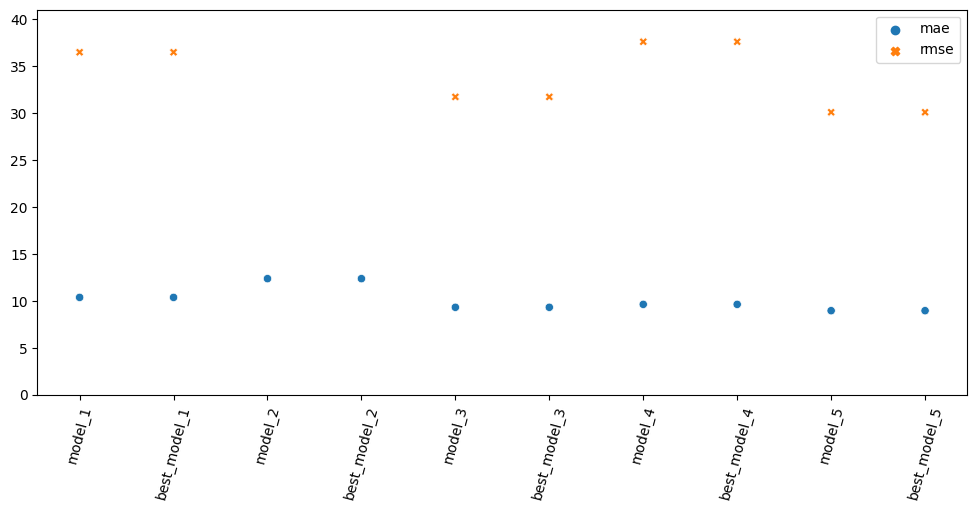

In [33]:
res_df = pd.DataFrame(res_dict).T

f, ax = plt.subplots(figsize=(12, 5))
sns.scatterplot(res_df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 75);
ax.set_ylim(0, 41)

# Predict on test dataset

In [34]:
# select last 49 weeks from data (max_encoder_length is 49)
past_data = df[df["time_idx"] > df["time_idx"].max()-max_pred_len]
past_data

,latitude,longitude,week_no,ID_LAT_LON_YEAR_WEEK,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,Mask,relative_year,time_idx
110,-0.510,29.290,4,ID_-0.510_29.290_2021_04,-0.000009,0.766009,-0.000020,0.116832,30.828970,45.473307,-140.225195,24.555187,0.000002,0.036051,2022.971317,1875.323382,829643.255201,29.314428,45.574219,-140.233280,24.539437,0.000042,0.000015,0.000028,0.000092,8288.049008,-2.135162,0.082883,829672.753838,30.828970,45.473307,-140.225195,24.555187,0.000085,1.111039,0.000043,0.116832,24.555187,-140.225195,45.473307,30.828970,-1.801412,829796.440978,-25.190170,41.497361,-135.039613,26.782317,0.113195,2.586095,0.297127,224.685280,0.405148,-25.190170,41.497361,-135.039613,26.782317,0.596678,53217.621213,5616.146900,59267.038012,4707.660364,7.747805,0.268286,-65.206115,45.831876,-132.634760,28.215139,4.161754,1,2,110
111,-0.510,29.290,5,ID_-0.510_29.290_2021_05,0.000120,0.763368,0.000092,0.017816,72.167415,58.859640,-150.116079,18.429419,0.000035,0.042727,1764.810582,2878.330914,829718.963758,24.692739,37.811648,-134.218882,24.462756,0.000046,0.000019,0.000027,0.000118,9579.218260,-1.690745,0.057259,829418.000000,72.167415,58.859640,-150.116079,18.429419,0.000255,1.052218,0.000211,0.195180,21.640310,-141.358554,30.464770,74.837244,-1.532790,829786.569907,0.045081,34.597696,-132.541600,24.755144,0.116092,2.495488,0.294055,225.135903,0.621200,0.045081,34.597696,-132.541600,24.755144,0.604542,46547.248679,6910.328195,52854.524933,5910.328209,14.699557,0.240911,0.049919,34.559715,-132.537165,24.766424,4.221930,1,2,111
112,-0.510,29.290,6,ID_-0.510_29.290_2021_06,0.000340,0.745717,0.000286,0.119933,17.033115,37.388402,-127.991482,22.949592,0.000127,0.054472,1877.149109,2006.302307,829861.781250,-12.465080,33.060766,-123.705219,25.530873,0.000036,0.000006,0.000030,0.000084,8613.444803,-1.685754,0.085986,829889.447623,-11.194155,33.

In [35]:
# The testing data consists of records from the first 49 weeks of 2022 for 487 different localizations
#test_df = pd.read_csv("/kaggle/input/playground-series-s3e20/test.csv")    

test_df["relative_year"] = test_df["year"] - 2019
test_df["time_idx"] = test_df["relative_year"] * 53 + test_df["week_no"]

test_df = pd.concat([past_data, test_df])
test_df = test_df.sort_values(["latitude", "longitude", "time_idx"]).reset_index(drop=True)

test_df["emission"].fillna(method='ffill', inplace=True)
test_df.fillna(0, inplace=True)

test_df.tail(2)

,latitude,longitude,week_no,ID_LAT_LON_YEAR_WEEK,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,Mask,relative_year,time_idx,year,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle
48704,-0.51,29.29,47,ID_-0.510_29.290_2022_47,0.000103,1.117813,0.000122,0.186502,49.047828,33.562886,-134.516512,29.12158,0.000061,0.033515,1744.508171,3442.849524,829868.278948,9.017690,35.018145,-130.678604,32.104737,0.000039,0.000002,0.000037,0.00009,8613.435216,-2.372491,0.09799,829857.526786,24.564079,31.119588,-132.146942,30.844543,0.000015,1.712174,-0.000076,0.217372,30.115173,-133.166239,34.687414,30.502313,-1.837097,829886.299856,4.899410,40.493340,-130.678844,32.436975,0.123353,2.690248,0.335407,229.217325,0.323504,4.896506,40.527934,-130.682563,32.432601,0.207355,52233.988712,5792.441503,57669.256366,4974.959629,6.168112,0.305673,30.723138,36.903808,-132.717798,30.637714,4.26951,0.0,3,206,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48705,-0.51,29.29,48,ID_-0.510_29.290_2022_48,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.035936,2156.339559,3937.792956,829990.804524,-12.439024,33.343445,-128.803382,34.860939,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000006,1.439919,-0.000049,0.436003,34.699890,-128.395279,22.875967,-101.046822,-1.296521,830032.341252,-56.150972,28.048814,-128.618968,34.768088,0.121057,2.411936,0.296352,229.088255,0.672869,-56.151141,28.048824,-128.614836,34.766462,0.575004,54709.837891,5318.210083,61787.458984,4318.210083,6.214988,0.314417,-56.150660,28.048862,-128.626770,34.771171,4.26951,0.0,3,207,2022.0,0.0,0.0,0.

In [37]:
columns = ['time_idx','emission','latitude', 'longitude', "relative_year", "week_no",
           'SulphurDioxide_SO2_column_number_density', 
           'SulphurDioxide_SO2_column_number_density_amf', 'SulphurDioxide_SO2_slant_column_number_density', 
           'SulphurDioxide_cloud_fraction', 'SulphurDioxide_SO2_column_number_density_15km',
           'CarbonMonoxide_CO_column_number_density', 'CarbonMonoxide_H2O_column_number_density', 
           'CarbonMonoxide_cloud_height', 'NitrogenDioxide_NO2_column_number_density',
           'NitrogenDioxide_tropospheric_NO2_column_number_density', 'NitrogenDioxide_stratospheric_NO2_column_number_density', 
           'NitrogenDioxide_NO2_slant_column_number_density', 'NitrogenDioxide_tropopause_pressure', 
           'NitrogenDioxide_absorbing_aerosol_index', 'NitrogenDioxide_cloud_fraction', 
           'Formaldehyde_tropospheric_HCHO_column_number_density', 'Formaldehyde_tropospheric_HCHO_column_number_density_amf', 
           'Formaldehyde_HCHO_slant_column_number_density', 'Formaldehyde_cloud_fraction', 
           'UvAerosolIndex_absorbing_aerosol_index', 'Ozone_O3_column_number_density',
           'Ozone_O3_column_number_density_amf', 'Ozone_O3_slant_column_number_density', 
           'Ozone_O3_effective_temperature', 'Ozone_cloud_fraction', 
           'Cloud_cloud_fraction', 'Cloud_cloud_top_pressure', 'Cloud_cloud_top_height', 'Cloud_cloud_base_pressure', 'Cloud_cloud_base_height', 'Cloud_cloud_optical_depth', 'Cloud_surface_albedo', 'relative_year', 'time_idx', 'week_no', 'year', 'CarbonMonoxide_sensor_altitude', 'CarbonMonoxide_sensor_altitude', 'CarbonMonoxide_sensor_azimuth_angle', 'CarbonMonoxide_sensor_zenith_angle', 'CarbonMonoxide_solar_azimuth_angle', 'CarbonMonoxide_solar_zenith_angle', 'Cloud_sensor_azimuth_angle', 'Cloud_sensor_zenith_angle', 
           'Cloud_solar_azimuth_angle', 'Cloud_solar_zenith_angle', "Mask",
]

columns = list(set(columns))
pd.DataFrame(test_df[columns].fillna(0))

,CarbonMonoxide_H2O_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,week_no,time_idx,Ozone_O3_effective_temperature,emission,Cloud_cloud_base_height,SulphurDioxide_SO2_column_number_density_15km,Formaldehyde_tropospheric_HCHO_column_number_density_amf,NitrogenDioxide_tropopause_pressure,Cloud_cloud_top_pressure,longitude,CarbonMonoxide_sensor_zenith_angle,NitrogenDioxide_cloud_fraction,Formaldehyde_tropospheric_HCHO_column_number_density,SulphurDioxide_SO2_column_number_density,Ozone_O3_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,Formaldehyde_cloud_fraction,UvAerosolIndex_absorbing_aerosol_index,NitrogenDioxide_NO2_column_number_density,year,Cloud_solar_zenith_angle,Mask,CarbonMonoxide_sensor_azimuth_angle,NitrogenDioxide_absorbing_aerosol_index,Cloud_sensor_zenith_angle,CarbonMonoxide_cloud_height,latitude,CarbonMonoxide_solar_azimuth_angle,Cloud_cloud_base_pressure,relative_year,Formaldehyde_HCHO_slant_column_number_density,Cloud_sensor_azimuth_angle,NitrogenDioxide_tropospheric_NO2_column_number_density,Cloud_cloud_optical_depth,SulphurDioxide_SO2_slant_column_number_density,Cloud_solar_azimuth_angle,Ozone_cloud_fraction,CarbonMonoxide_sensor_altitude,Cloud_cloud_fraction,Cloud_cloud_top_height,SulphurDioxide_SO2_column_number_density_amf,CarbonMonoxide_solar_zenith_angle,SulphurDioxide_cloud_fraction,Ozone_O3_slant_column_number_density,CarbonMonoxide_CO_column_number_density,Cloud_surface_albedo,Ozone_O3_column_number_density_amf
0,2744.265808,0.000062,4,110,221.902484,26.859753,3950.520211,0.000054,1.360477,8353.145955,58456.062060,30.301,33.859910,0.229656,0.000064,0.000127,0.111837,0.000030,0.251743,-1.846648,0.000028,0.0,26.737835,1.0,-34.938255,-2.355408,38.513846,3457.481979,-3.299,-130.754721,66061.443579,2,0.000026,-47.540167,0.000004,19.108706,0.000119,-128.712251,0.547295,830162.234375,0.547299,4938.876860,0.936891,25.345272,0.174019,0.286252,0.030868,0.277596,2.517056
1,1836.098802,0.000000,5,111,227.478896,27.812828,5149.584589,0.000000,0.000000,0.000000,50161.678591,30.301,39.403775,0.000000,0.000000,0.000000,0.115487,0.000000,0.000000,-1.426650,0.000000,0.0,24.323214,1.0,-11.064961,0.000000,34.896978,3244.417688,-3.299,-129.731249,56815.181654,2,0.000000,-25.298108,0.000000,15.132386,0.000000,-126.736999,0.772342,830095.417940,0.771916,6149.584520,0.000000,23.886205,0.000000,0.294254,0.031739,0.270741,2.510485
2,1935.423889,0.000000,6,112,226.639686,27.254847,4563.018250,0.000000,1.927041,0.000000,54002.577763,30.301,51.803961,0.000000,0.000106,0.000000,0.115846,0.000000,0.360026,-1.234325,0.000000,0.0,19.737537,1.0,-12.597244,0.000000,43.959066,3206.952515,-3.299,-125.078537,60026.905110,2,0.000142,24.247510,0.000000,32.924207,0.000000,-129.216737,0.878806,830103.968750,0.878265,5457.639295,0.000000,23.485447,0.000000,0.314404,0.044021,0.265297,2.672174
3,4624.272217,0.000065,7,113,228.930502,27.208376,7931.480511,0.000000,1.010982,8613.459566,36004.208435,30.301,45.671483,0.108632,0.000065,0.000000,0.117642,0.000031,0.287031,-1.059605,0.000026,0.0,24.164035,1.0,-11.929108,-2.983068,43.627085,4744.354004,-3.299,-115.475052,40948.092287,2,0.000016,-49.942259,-0.000004,34.557241,0.000000,-114.549579,0.695575,830212.593750,0.690316,8931.480431,0.000000,24.124682,0.000000,0.315743,0.043003,0.280638,2.645291
4,1957.076834,0.000085,8,114,228.516569,27.313541,5403.317635,-0.000065,1.641825,9096.416311,48867.359020,30.301,44.667513,0.117748,0.000124,-0.000283,0.118631,0.000029,0.198298,-1.439332,0.000043,0.0,19.587672,1.0,-41.151703,-1.439279,34.988075,2589.444145,-3.299,-108.601847,55120.507805,2,0.000063,-0.336500,0.000014,32.727065,-0.000150,-111.981912,0.664689,830200.984932,0.661497,6383.301417,0.530021,22.228282,0.052905,0.300156,0.043443,0.268834,2.492317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4

In [51]:
model = model_3

In [52]:
new_time_idx =[df["time_idx"].max() + 1+ i for i in range(max_pred_len)]

raw_predictions = model.predict(pd.DataFrame(test_df[columns].fillna(0)), 
                                mode="prediction", return_x=False, return_index=True )

predictions_df = raw_predictions.index.drop("time_idx", axis=1)
predictions_df["predictions"] = raw_predictions.output.tolist()
predictions_df = predictions_df.explode("predictions")
predictions_df["time_idx"] = new_time_idx * n_locations

# emissions can not be negative
predictions_df.loc[predictions_df["predictions"] < 0, "predictions"] = 0

predictions_df = pd.merge(test_df.drop("emission", axis=1), predictions_df, 
                          left_on=["latitude", "longitude", "time_idx"], 
                          right_on=["latitude", "longitude", "time_idx"])

predictions_df

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


,latitude,longitude,week_no,ID_LAT_LON_YEAR_WEEK,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,Mask,relative_year,time_idx,year,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,predictions
0,-3.299,30.301,0,ID_-3.299_30.301_2022_00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-0.830912,830359.812500,-99.829460,39.428516,-129.183456,33.261436,0.115389,2.469392,0.289322,230.784927,1.000000,-99.829460,39.428516,-129.183456,33.261436,1.000000,40894.914062,7548.382324,46233.054687,6548.382324,8.936213,0.279406,-99.829468,39.428608,-129.183441,33.261452,0.0,3,159,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.670713
1,-3.299,30.301,1,ID_-3.299_30.301_2022_01,-0.000049,1.340632,-0.000065,0.230405,-81.993462,40.665873,-129.176910,32.630626,-0.000026,0.033047,1808.961529,3207.914226,830256.369359,-68.559225,43.834455,-130.309817,32.285954,0.000048,0.000011,0.000037,0.000109,9352.614891,-0.842918,0.102847,830331.941221,-81.993447,40.665889,-129.176379,32.630413,0.000094,2.085175,1.351604e-04,0.230405,32.630626,-129.176910,40.665873,-81.993462,-0.768181,830270.066435,-62.251581,41.204522,-131.152866,31.694686,0.113131,2.620810,0.300815,228.321281,0.423117,-62.251581,41.204510,-131.152868,31.694684,0.450769,68951.202718,3511.963141,74575.986502,2791.303804,21.441379,0.213045,-59.155577,43.960234,-130.925393,31.856934,0.0,3,160,2022.0,0.0,0.0,0.0,0.0,0.0

In [53]:
predictions_df.rename(columns={"predictions": "emission"}, inplace=True)
predictions_df[["ID_LAT_LON_YEAR_WEEK", "emission"]].to_csv('data/submission.csv', index=False)

In [54]:
predictions_df[["ID_LAT_LON_YEAR_WEEK", "emission"]]

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-3.299_30.301_2022_00,25.670713
1,ID_-3.299_30.301_2022_01,23.153984
2,ID_-3.299_30.301_2022_02,24.258282
3,ID_-3.299_30.301_2022_03,24.185919
4,ID_-3.299_30.301_2022_04,24.710541
...,...,...
24348,ID_-0.510_29.290_2022_44,4.157145
24349,ID_-0.510_29.290_2022_45,4.117386
24350,ID_-0.510_29.290_2022_46,4.093071
24351,ID_-0.510_29.290_2022_47,4.11074


In [55]:
predictions_df[["ID_LAT_LON_YEAR_WEEK", "emission"]]

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-3.299_30.301_2022_00,25.670713
1,ID_-3.299_30.301_2022_01,23.153984
2,ID_-3.299_30.301_2022_02,24.258282
3,ID_-3.299_30.301_2022_03,24.185919
4,ID_-3.299_30.301_2022_04,24.710541
...,...,...
24348,ID_-0.510_29.290_2022_44,4.157145
24349,ID_-0.510_29.290_2022_45,4.117386
24350,ID_-0.510_29.290_2022_46,4.093071
24351,ID_-0.510_29.290_2022_47,4.11074
